In [2]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

from src.models import ResNet50
from src.utils.common import UnCallBack
from src.utils.evaluate import makeEval
from src.utils.data_loaders import train_val_dataloader, test_dataloader, train_dataloader
%matplotlib inline

In [3]:
def commonArguments( test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = ResNet50()
    loss_fn = nn.CrossEntropyLoss(reduction='none')
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3 )

    eval_callback = makeEval(test_loader, loss_fn, device)

    return {"model":model, "optimizer":optimizer, "loss_fn":loss_fn, "eval":eval_callback, "device":device}


In [4]:
%load_ext autoreload
%aimport src.utils.common
%aimport src.utils.evaluate
%aimport src.train_importance_sampling
%aimport src.train_rho_loss
%aimport src.train_apricot
%aimport src.train_schaul
%autoreload 1

All learning algorithms are enclosed in functions to avoid memory problems. We avoid using global variables to allow the garbage collector to free up memory

# Upper-bound and/or Loss

To use Upper-bound method use use_loss_estimation = False, \
for Loss use use_loss_estimation = True

In [5]:
from src.train_importance_sampling import  train_full_upper_bound

def upperBoundOrLoss(train_loader, test_loader, n_epochs = 50, use_loss_estimation = False):
    
    if use_loss_estimation:
        print("upper-bound based algorithm")
    else:
        print("loss based algorithm") 

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    model = ResNet50()
    model.to(device)

    loss_fn = nn.CrossEntropyLoss(reduction='none')
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3 )

    callback = UnCallBack( info_list = ['train_loss', 'train_acc', 'train_w_loss', 'val_loss', 'val_acc', 'train_uniform_cnt'])

    eval_callback = makeEval(test_loader, loss_fn, device)

    train_full_upper_bound( model, 
                train_loader, 
                loss_fn, 
                optimizer, 
                n_epochs = n_epochs, 
                eval = eval_callback, 
                callback = callback, 
                presample = 3, 
                tau_th = None,
                use_loss_estimation = use_loss_estimation,
                second_approach = True,
                device= device)

    if use_loss_estimation:
        callback.save("callbacks/loss")
    else:
        callback.save("callbacks/upper_bound")

    return callback



# RHO-LOSS

In [6]:
from src.train_rho_loss import train_full_rho_loss
def rhoLoss(train_loader, test_loader, n_epochs = 50, train_irr_loader = None):
    print("RHO-LOSS based algorithm")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = ResNet50()
    model.to(device)

    model_irr = ResNet50()
    model_irr.to(device)


    loss_fn = nn.CrossEntropyLoss(reduction='none')
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3 )
    optimizer_irr = torch.optim.Adam(model_irr.parameters(), lr = 1e-3 )

    callback = UnCallBack( info_list = ['train_loss', 'train_acc', 'train_w_loss', 'val_loss', 'val_acc', 'train_uniform_cnt'])

    eval_callback = makeEval(test_loader, loss_fn, device)

    train_full_rho_loss(model, 
            model_irr,
            train_loader, 
            train_irr_loader,
            loss_fn, 
            optimizer, 
            optimizer_irr,
            n_epochs=n_epochs, 
            eval=eval_callback, 
            callback=callback, 
            presample=3, 
            device = device)
    
    callback.save("callbacks/rho_loss")

# Apricot

In [7]:
from src.train_apricot import train_full_apricot
def apricot(train_loader, test_loader, n_epochs = 50):
    print("apricot algorithm")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    model = ResNet50()
    model.to(device)

    loss_fn = nn.CrossEntropyLoss(reduction='none')
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3 )

    callback = UnCallBack( info_list = ['train_loss', 'train_acc', 'train_w_loss', 'val_loss', 'val_acc', 'train_uniform_cnt'])

    train_full_apricot(
        model, 
        train_loader,
        test_loader,
        loss_fn,
        optimizer,
        n_epochs = 50,
        callback = callback,
        device=device)
    
    callback.save("callbacks/apricot")

# Schaul training 

In [8]:
%autoreload 1
from src.train_schaul import train_full_schaul, train_full_schaul2


def schaul(train_loader, test_loader, n_epochs = 50):
    print("schaul algorithm")

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = ResNet50()
    model.to(device)

    loss_fn = nn.CrossEntropyLoss(reduction='none')
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3 )

    callback = UnCallBack( info_list = ['train_loss', 'train_acc', 'val_loss', 'val_acc'])


    eval_callback = makeEval(test_loader, loss_fn, device)

    train_full_schaul(model, 
                    train_loader, 
                    loss_fn, 
                    optimizer, 
                    n_epochs = n_epochs, 
                    eval = eval_callback, 
                    callback = callback, 
                    device = device)

    callback.save("callbacks/schaul")
    return callback

# Loshchilov training 

In [9]:
from src.train_loshchilov import train_full_loshchilov

def loshchilov(train_loader, test_loader, n_epochs = 50):
    print("loshchilov algorithm")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = ResNet50()
    model.to(device)

    loss_fn = nn.CrossEntropyLoss(reduction='none')
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3 )

    callback = UnCallBack( info_list = ['train_loss', 'train_acc', 'val_loss', 'val_acc'])

    eval_callback = makeEval(test_loader, loss_fn, device)

    train_full_loshchilov(model, 
                        train_loader, 
                        loss_fn, 
                        optimizer, 
                        n_epochs=n_epochs, 
                        eval = eval_callback, 
                        callback=callback, 
                        device = device)

    callback.save("callbacks/loshchilov")

    return callback

# Run 

In [10]:
%autoreload 1
callback = UnCallBack( info_list = ['train_loss', 'train_acc', 'val_loss', 'val_acc'])
callback.save("callbacks/loshchilov")

In [12]:
%autoreload 1
n_epochs = 2



######################################################################
train_loader = train_dataloader(batch_size=120)
test_loader = test_dataloader(batch_size=120)

# run upper-bound algorithm
callback_upper_bound = upperBoundOrLoss(train_loader, test_loader, n_epochs)
# run loss based algorithm
callback_loss = upperBoundOrLoss(train_loader, test_loader, n_epochs, use_loss_estimation=True)



######################################################################
train_irr_loader  = train_dataloader(batch_size=300, subset=0.25)
# wee need indexes of data to use precomputed irreduseble loses 
train_loader  = train_dataloader(batch_size=300, index = True) 

# run rho-loss based algorithm
callback_rho_loss = rhoLoss(train_loader, test_loader, n_epochs, train_irr_loader= train_irr_loader)



######################################################################
train_loader = train_dataloader(batch_size=80)

train_loader, test_loader = train_val_dataloader(batch_size=120)
schaul_callback = schaul(train_loader, test_loader, n_epochs)


train_loader = train_dataloader(batch_size=64)
loshchilov_callback = loshchilov(train_loader, test_loader, n_epochs)


# it is better to run it separately because 
# this algorithm wasn't optimised on memory usage 
#####################################################################
#train_loader = train_dataloader(batch_size=120)
#callback_apricot = apricot(train_loader, test_loader, n_epochs)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
schaul algorithm


Epochs: 100%|██████████| 2/2 [03:18<00:00, 99.41s/it, train_loss=0.047, train_acc=0.254, val_loss=3.639, val_acc=0.101]


Files already downloaded and verified
loshchilov algorithm


Epochs: 100%|██████████| 2/2 [07:14<00:00, 217.23s/it, train_loss=0.869, train_acc=0.686, val_loss=4.161, val_acc=0.099]


# How to plot the logs

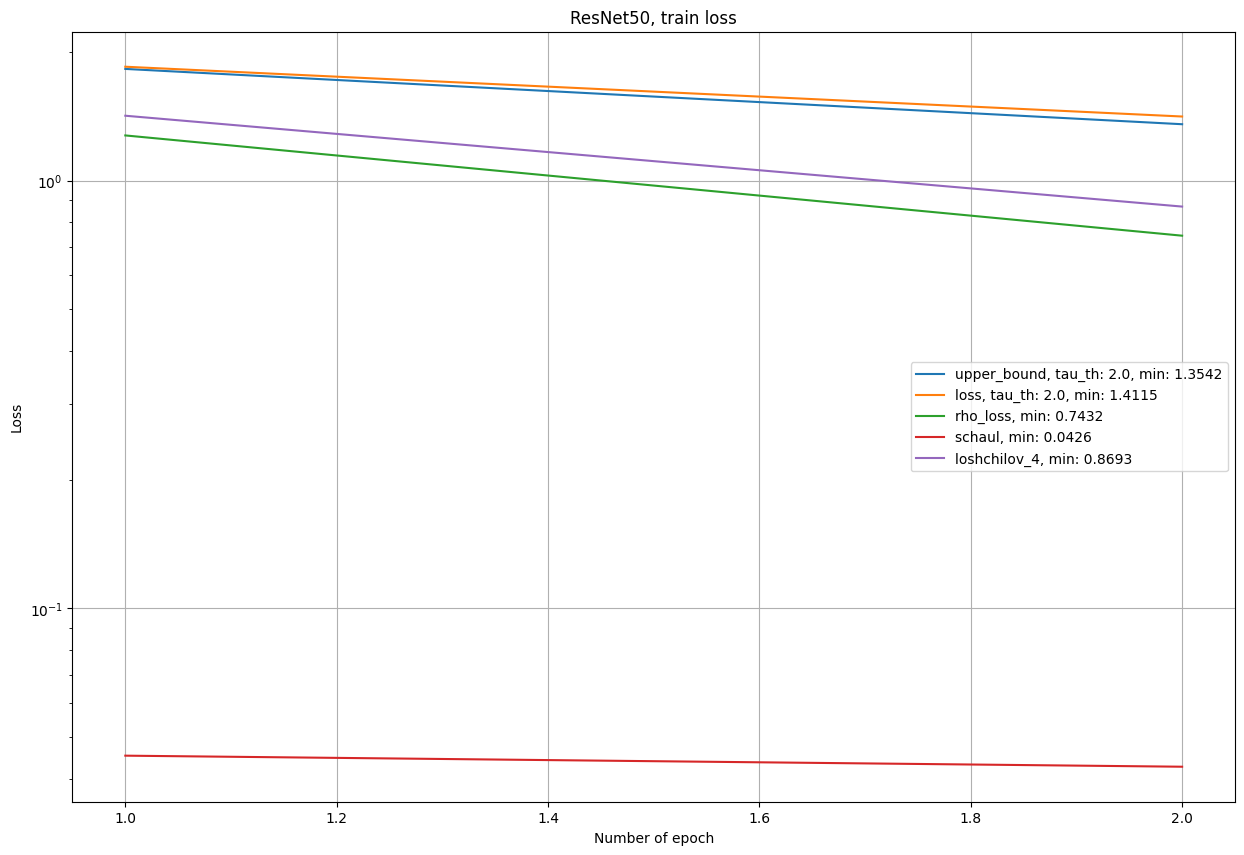

In [22]:
from src.utils.common import UnCallBack
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


methods = ["upper_bound","loss","rho_loss", "schaul", "loshchilov_4" ]

callabacks = []
for name in methods:
    try: 
        callaback =  UnCallBack.load(f"callbacks/{name}.pickle")
        callaback.meta["name"] = name
        callabacks.append(callaback)
    except:
        print(f"can't fild the callbacks/{name}.pickle")



plt.figure(figsize=(15, 10))
plt.title('ResNet50, train loss')
plt.xlabel('Number of epoch')
plt.ylabel('Loss')

def smoth(x, N_ = 5):
    return np.convolve([1.0/N_]*N_,x,"valid")

length = min( len(i.train_loss) for i in callabacks)

for callback in callabacks:
    suffix = ""
    if "tau_th" in callback.meta:
        suffix = f', tau_th: {callback.meta["tau_th"]}'
    name = callback.meta["name"]
    min_loss = min(callback.train_loss[0:length])
    y = smoth(callback.train_loss[0:length],1)
    epochs = np.arange(length) + 1
    plt.plot(epochs, y , label=f'{name}{suffix}, min: {min_loss:.4f}')

plt.legend()
plt.yscale("log")
plt.grid(True)
plt.show()

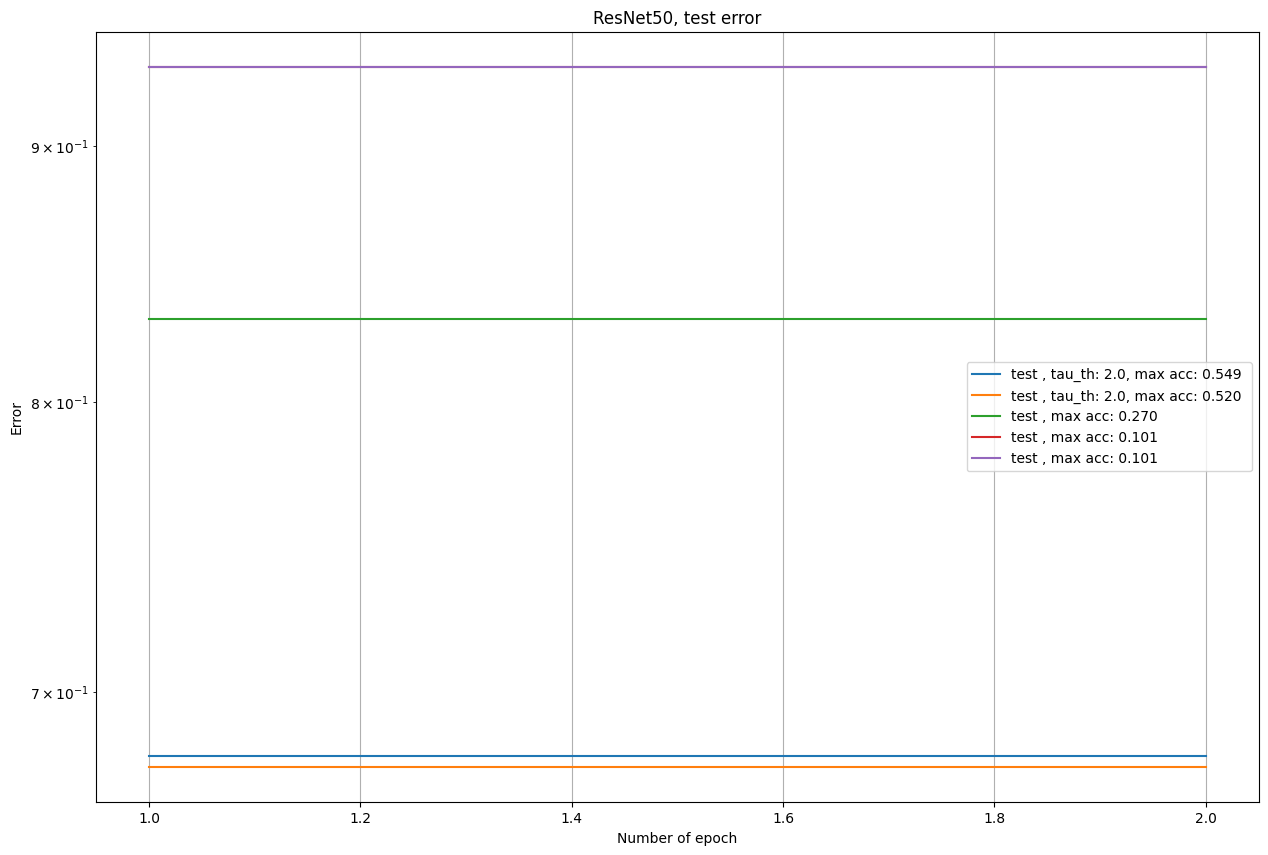

In [23]:
plt.figure(figsize=(15, 10))
plt.title('ResNet50, test error')
plt.xlabel('Number of epoch')
plt.ylabel('Error')

for callback in callabacks:
    suffix = ""
    if "tau_th" in callback.meta:
        suffix = f', tau_th: {callback.meta["tau_th"]}'
    name = callback.meta["name"]

    acc  = callback.val_acc[0:length]
    min_loss = min(acc)
    acc = smoth(acc,3)
    #y = np.array(callback.val_acc)
    epochs = np.arange(len(acc)) + 1
    #plt.plot(epochs,1- np.array(callback.train_acc), label='Train'+suffix)
    plt.plot(epochs, 1- acc , label=f'test {suffix}, max acc: {max(callback.val_acc):.3f} ' )
plt.yscale("log")
plt.legend()
plt.grid(True)